In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np
import pathlib; from pathlib import Path; import pandas as pd; import flopy

In [2]:
example_name = "MT3D_tutorial_06ii"
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D


In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'ex-RES'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace)                 # output_folder = Path('ex-RES\\p06') ; output_folder.mkdir(exist_ok=True)

In [4]:
def p06(dirname, mixelm, dt0):
    model_ws = os.path.join(workspace, dirname)
    nlay = 1 ;  nrow = 31 ;  ncol = 31 ;  delr = 900 ;  delc = 900 ;  delv = 20 ;  prsity = 0.30 ;  al = 100.0 ;  trpt = 1.0 ;  
    q0 = 86400.0 ;  c0 = 100.0 ;  perlen_mf = [912.5, 2737.5] ; perlen_mt = perlen_mf ; hk = 0.005 * 86400;     laytyp = 0

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=0.0,botm=[0 - delv],nper=2, perlen=perlen_mf)  # nper=2
    ibound = np.ones((nlay, nrow, ncol), dtype=int) * -1 ; ibound[ : ,1:nrow-1 ,1:ncol-1 ] = 1     ; strt = 0.0

    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    welspd = {0: [[0, 15, 15, q0]], 1: [[0, 15, 15, -q0]]}    # ___ injection / extraction, _____ steady state instantaneously
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    sip = flopy.modflow.ModflowSip(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt,model_ws=model_ws,exe_name=exe_name_mt,modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt,icbund=1,prsity=prsity,sconc=0,nper=2,perlen=perlen_mt,dt0=dt0,   obs=[(0, 15, 15)])
    dceps = 1.0e-5 ;  nplane = 1 ;  npl = 16 ;  nph = 16 ;  npmin = 4 ;  npmax = 32 ;  dchmoc = 1.0e-3 ;  nlsink = nplane; npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt,mixelm=mixelm,dceps=dceps,nplane=nplane,npl=npl,
                             nph=nph,npmin=npmin,npmax=npmax,nlsink=nlsink,npsink=npsink, percel=0.5)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)               ; spd = {0: [0, 15, 15, c0, 2], 1: [0, 15, 15, 0.0, 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)                                 ; mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    fname = os.path.join(model_ws, "MT3D001.UCN")  ; ucnobj = flopy.utils.UcnFile(fname) ; times = ucnobj.get_times()  ; conc = ucnobj.get_alldata()
    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None
    fname = os.path.join(model_ws, "MT3D001.MAS")      ; mvt = mt.load_mas(fname)
    return mf, mt, conc, cvt, mvt

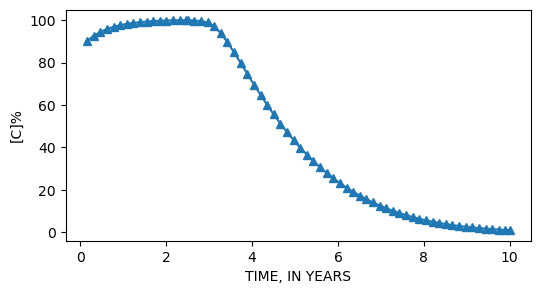

In [5]:
mf, mt, conc, cvt, mvt = p06("p06", -1, 56.25)   # _______________ Mixem ____________1 , -1 , 0    
fig = plt.figure(figsize=(6, 3))  ; ax = fig.add_subplot(1, 1, 1)
plt.xlabel("TIME, IN YEARS")  ; plt.ylabel("[C]%")
x = cvt["time"] / 365.0  ; y = cvt["(1, 16, 16)"]  ; ax.plot(x, y, label="MOC", marker="^")

In [6]:
print(cvt.shape) # x,y

(66,)


In [7]:
print(conc.shape)

(2, 1, 31, 31)


In [8]:
# MT3D001.MAS ...... E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D\C_p06_V01\ex-gwt-mt3dms-p06\mt3d\MT3D001.MAS (txt)

In [9]:
A = np.linspace(0, 10, 5, endpoint = False); print('timprs = ',A)

timprs =  [0. 2. 4. 6. 8.]


In [10]:
B = np.linspace(100, 120, 5, endpoint = False); print('timprs = ',B)

timprs =  [100. 104. 108. 112. 116.]


In [11]:
np.append([A],[B])

array([  0.,   2.,   4.,   6.,   8., 100., 104., 108., 112., 116.])